In [ ]:
!pip install fosforml

In [1]:
from fosforml.model_manager.snowflakesession import get_session

my_session = get_session()

In [2]:
file_name = 'ATTRITION_PREDICTIVE_DATA'

In [3]:
sf_df = my_session.sql("select * from {}".format(file_name ))


In [4]:
import pandas as pd
pandas_df = sf_df.to_pandas()
#pandas_df = pd.read_csv(file_name)

In [5]:
print(pandas_df.isnull().sum())

EMPLOYEE_ID                      0
TENURE_MONTHS                    0
BIRTH_YEAR                       0
AGE                              0
SENIORITY                        0
SCHOOL_ENDDATE                   0
JOB_STARTDATE                    0
JOB_ENDDATE                  90076
CITY                             0
DISTANCE                         0
DEGREE_CLEAN                     0
ETHNICITY                        0
MARITAL_STATUS                   0
ROLE                             0
COMPANY_NAME                     0
ORGANIZATION_TYPE                0
ORGANIZATION_OWNERSHIP           0
STATE                            0
COUNTRY                          0
GENDER                           0
WORK_LIFE_BALANCE                0
BUSINESS_TRAVEL                  0
ENVIRONMENT_SATISFACTION         0
SALARY                           0
JOB_SATISFACTION                 0
PERCENTAGE_SALARY_HIKE           0
PERFORMANCE_RATING               0
OVER_TIME                        0
RELATIONSHIP_SATISFA

In [6]:
pandas_df = pandas_df.dropna()

In [7]:
print(pandas_df.isnull().sum())

EMPLOYEE_ID                  0
TENURE_MONTHS                0
BIRTH_YEAR                   0
AGE                          0
SENIORITY                    0
SCHOOL_ENDDATE               0
JOB_STARTDATE                0
JOB_ENDDATE                  0
CITY                         0
DISTANCE                     0
DEGREE_CLEAN                 0
ETHNICITY                    0
MARITAL_STATUS               0
ROLE                         0
COMPANY_NAME                 0
ORGANIZATION_TYPE            0
ORGANIZATION_OWNERSHIP       0
STATE                        0
COUNTRY                      0
GENDER                       0
WORK_LIFE_BALANCE            0
BUSINESS_TRAVEL              0
ENVIRONMENT_SATISFACTION     0
SALARY                       0
JOB_SATISFACTION             0
PERCENTAGE_SALARY_HIKE       0
PERFORMANCE_RATING           0
OVER_TIME                    0
RELATIONSHIP_SATISFACTION    0
CHURN                        0
dtype: int64


In [8]:
#dataset = pandas_df[["DISTANCE","DEGREE_CLEAN","ROLE","COMPANY_NAME","ORGANIZATION_TYPE","ORGANIZATION_OWNERSHIP","JOB_ENDDATE","CHURN"]]
dataset = pandas_df[["ORGANIZATION_TYPE","JOB_ENDDATE","CHURN"]]

In [9]:
print(dataset)

         ORGANIZATION_TYPE JOB_ENDDATE  CHURN
0       Financial Services  01-08-2019      1
1                Aerospace  01-06-2021      1
3       Financial Services  01-07-2017      1
4               E-commerce  01-08-2019      1
6               E-commerce  01-07-2018      1
...                    ...         ...    ...
299995          Investment  01-05-2023      1
299996          Technology  01-05-2023      1
299997       Environmental  01-05-2023      1
299998          Technology  01-05-2023      1
299999       Environmental  01-06-2023      1

[209924 rows x 3 columns]


In [10]:
dataset['JOB_ENDDATE'] = pd.to_datetime(dataset['JOB_ENDDATE'],format= '%d-%m-%Y').dt.strftime('%d-%m-%Y')

In [11]:
dataset.set_index('JOB_ENDDATE', inplace = True)

In [12]:
dataset.nunique()

ORGANIZATION_TYPE    16
CHURN                 1
dtype: int64

In [13]:
groupedDataset = dataset.groupby(["ORGANIZATION_TYPE","JOB_ENDDATE"]).agg({'CHURN': 'sum'}).reset_index()

In [14]:
groupedDataset['JOB_ENDDATE'] = pd.to_datetime(groupedDataset['JOB_ENDDATE'],format= '%d-%m-%Y')

In [15]:
date_start = pd.to_datetime('01-08-2022',format= '%d-%m-%Y')
end_date = pd.to_datetime('01-09-2024',format= '%d-%m-%Y')
filteredDataset = groupedDataset[(groupedDataset['JOB_ENDDATE'] > date_start) & (groupedDataset['JOB_ENDDATE'] < end_date)]

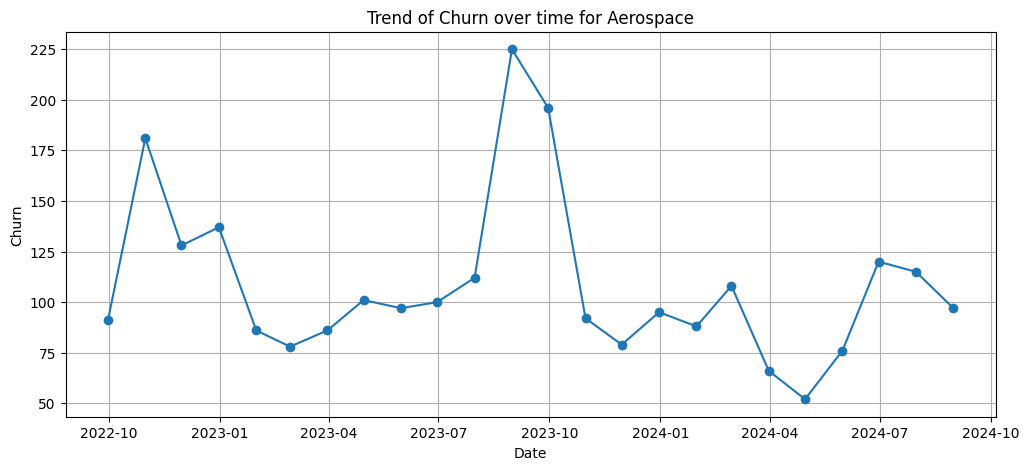

In [16]:
import matplotlib.pyplot as plt
aerospaceData = filteredDataset[filteredDataset['ORGANIZATION_TYPE']=='Aerospace']
aerospaceData['JOB_ENDDATE'] = pd.to_datetime(aerospaceData['JOB_ENDDATE'])
monthly_data = aerospaceData.resample('M', on='JOB_ENDDATE').sum()
plt.figure(figsize = (12,5))
plt.plot(monthly_data.index , monthly_data['CHURN'],  marker='o',  linestyle = '-')
plt.title('Trend of Churn over time for Aerospace')
plt.xlabel('Date')
plt.ylabel('Churn')
plt.grid(True)
plt.show()

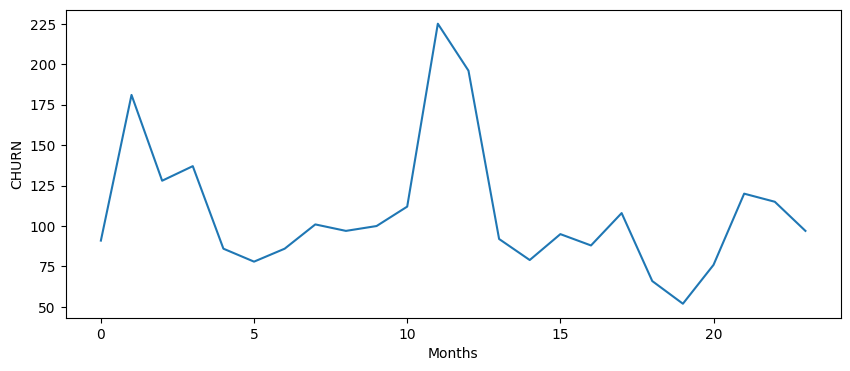

In [17]:
grouped_data = filteredDataset.groupby(['ORGANIZATION_TYPE' , pd.Grouper(key = 'JOB_ENDDATE', freq= 'M')]).sum().reset_index()
data = grouped_data[grouped_data['ORGANIZATION_TYPE']  == 'Aerospace']
final_dataset = data[['JOB_ENDDATE','CHURN']]
final_dataset['Month'] = final_dataset.index+1
plt.figure(figsize=(10,4))
plt.xlabel("Months")
plt.ylabel("CHURN")
plt.plot(final_dataset['CHURN'])

In [19]:
final_dataset['mavg_12']= final_dataset['CHURN'].rolling(window = 1).mean().shift(1)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
final_dataset[['CHURN', 'mavg_12']][1:]

,CHURN,mavg_12
1,181,91.00
2,128,181.00
3,137,128.00
4,86,137.00
5,78,86.00
6,86,78.00
7,101,86.00
8,97,101.00
9,100,97.00
10,112,100.00


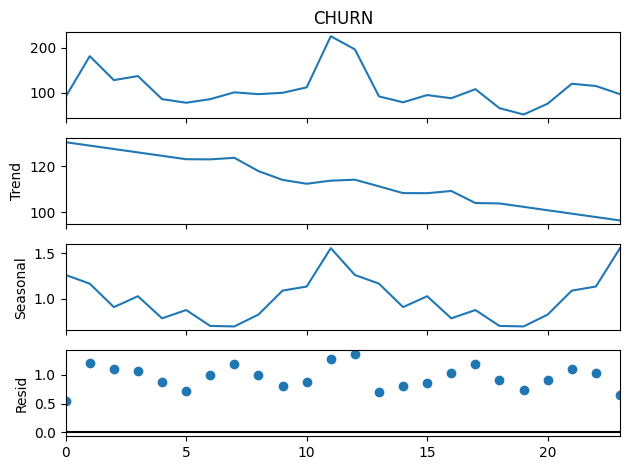

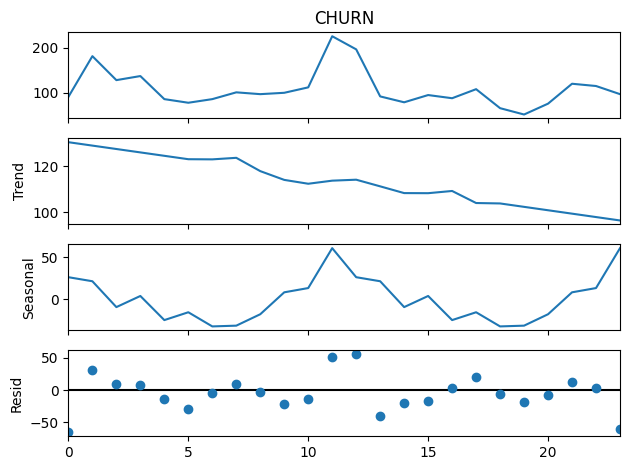

In [20]:
#Decomposing Time series

from statsmodels.tsa.seasonal import seasonal_decompose
ts_decompose_multiplicative = seasonal_decompose(final_dataset['CHURN'], model = 'multiplicative', period=12, extrapolate_trend = 'freq')
ts_decompose_additive = seasonal_decompose(final_dataset['CHURN'], model = 'additive', period=12, extrapolate_trend = 'freq')
#Plotting 
#ts_decompose.show()
ts_plot = ts_decompose_multiplicative.plot()
ts_plot = ts_decompose_additive.plot()

In [21]:
import warnings
warnings.filterwarnings("ignore")
df_decomposed = pd.concat([ts_decompose_multiplicative.seasonal, ts_decompose_multiplicative.trend, ts_decompose_multiplicative.resid, ts_decompose_multiplicative.observed], axis = 1)
df_decomposed.columns = ['seasonal', 'trend', 'residual', 'actual_values']
final_dataset.loc[:,'seasonal'] = df_decomposed.loc[:,'seasonal']
final_dataset.loc[:,'trend'] = df_decomposed.loc[:,'trend']
final_dataset.loc[:,'residual'] = df_decomposed.loc[:,'residual']

In [23]:
import warnings
warnings.filterwarnings("ignore")
final_dataset.loc[:,'MAvg_12']= final_dataset.loc[:,'CHURN'].rolling(window = 12).mean().shift(1)
pd.set_option('display.float_format', lambda x: '%.0f' % x)
final_dataset[['CHURN', 'MAvg_12']][12:]

,CHURN,MAvg_12
12,196,118
13,92,127
14,79,120
15,95,116
16,88,112
17,108,112
18,66,115
19,52,113
20,76,109
21,120,107


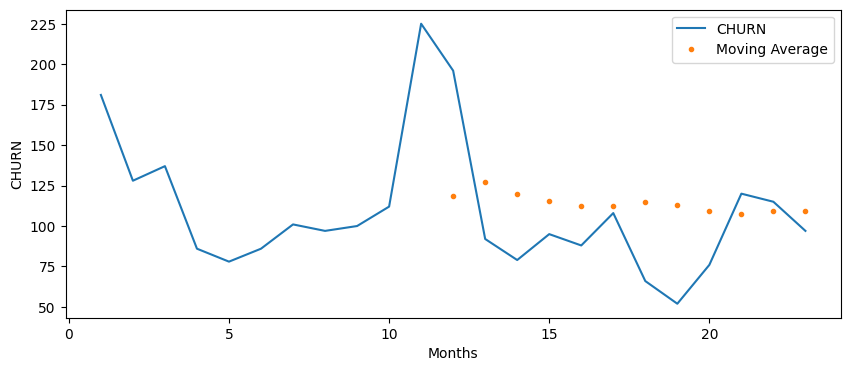

In [24]:
import warnings
warnings.filterwarnings("ignore")
plt.figure(figsize=(10,4))
plt.xlabel("Months")
plt.ylabel("CHURN")
plt.plot(final_dataset['CHURN'][1:])
plt.plot(final_dataset['MAvg_12'][1:], '.')
plt.legend(['CHURN','Moving Average'])

In [25]:
# Defining Mape Function
import numpy as np
def get_mape(actual, predicted):
    y_true , y_pred = np.array(actual) , np.array(predicted)
    return np.round(np.mean(np.abs((y_true-y_pred)/y_true))*100, 2)

In [26]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
mae_mavg = mean_absolute_error(final_dataset['CHURN'][12:].values , final_dataset['MAvg_12'][12:].values)
mse_mavg = mean_squared_error(final_dataset['CHURN'][12:].values , final_dataset['MAvg_12'][12:].values)
mape_mavg = get_mape(final_dataset['CHURN'][12:].values , final_dataset['MAvg_12'][12:].values)
rmse_mavg = np.sqrt(mse_mavg)
print('Mape error in moving average is', mape_mavg , '%.')
print('Mean Absoulte Error in moving average is', mae_mavg )
print('Mean Squared Error in moving average is', mse_mavg )
print('Root Mean Squared Error in moving average is', rmse_mavg )

Mape error in moving average is 37.24 %.
Mean Absoulte Error in moving average is 31.430555555555554
Mean Squared Error in moving average is 1462.0162037037035
Root Mean Squared Error in moving average is 38.23632047809652


In [27]:
#Exponential Smoothing
final_dataset.loc[:,'EWM'] = final_dataset.loc[:,'CHURN'].ewm(alpha = 0.2).mean()
final_dataset[12:]

,JOB_ENDDATE,CHURN,Month,mavg_12,seasonal,trend,residual,MAvg_12,EWM
12,2023-09-30,196,13,225,1,114,1,118,144
13,2023-10-31,92,14,196,1,111,1,127,133
14,2023-11-30,79,15,92,1,108,1,120,122
15,2023-12-31,95,16,79,1,108,1,116,116
16,2024-01-31,88,17,95,1,109,1,112,110
17,2024-02-29,108,18,88,1,104,1,112,110
18,2024-03-31,66,19,108,1,104,1,115,101
19,2024-04-30,52,20,66,1,102,1,113,91
20,2024-05-31,76,21,52,1,101,1,109,88
21,2024-06-30,120,22,76,1,99,1,107,94


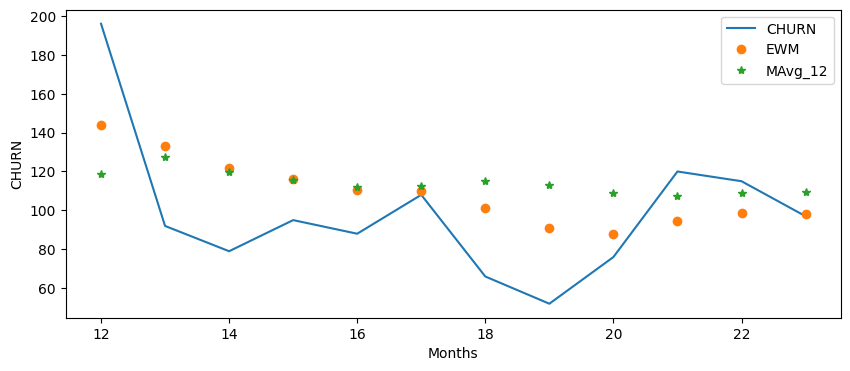

In [28]:
plt.figure(figsize=(10,4))
plt.xlabel("Months")
plt.ylabel("CHURN")
plt.plot(final_dataset['CHURN'][12:])
plt.plot(final_dataset['EWM'][12:], 'o')
plt.plot(final_dataset['MAvg_12'][12:], '*')
plt.legend(['CHURN','EWM','MAvg_12'])

In [29]:
mae_ewm = mean_absolute_error(final_dataset['CHURN'][12:].values , final_dataset['EWM'][12:].values)
mse_ewm = mean_squared_error(final_dataset['CHURN'][12:].values , final_dataset['EWM'][12:].values)
mape_ewm = get_mape(final_dataset['CHURN'][12:].values , final_dataset['EWM'][12:].values)
rmse_ewm = np.sqrt(mse_ewm)
print('Mape = ', mape_ewm , '%.')
print('MAE = ', mae_ewm )
print('MSE = ', mse_ewm )
print('RMSE = ', rmse_ewm )

print('Error reduced by', (mape_mavg-mape_ewm)*100/mape_mavg , '%')

Mape =  29.65 %.
MAE =  25.905557153967468
MSE =  917.569636697618
RMSE =  30.291411929746985
Error reduced by 20.381310418904413 %


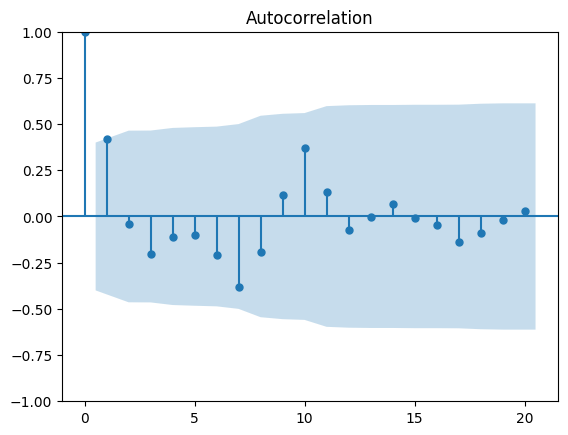

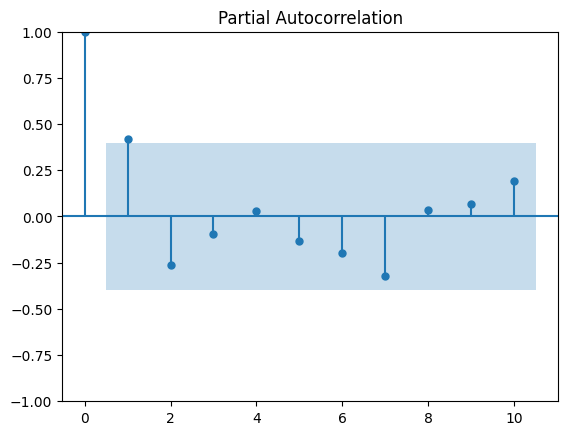

In [30]:
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf

acf_plot = plot_acf(final_dataset.CHURN, lags =20)
pacf_plot = plot_pacf(final_dataset.CHURN , lags =10)

In [31]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.arima.model import ARIMA
arima_model_1 = ARIMA(final_dataset['CHURN'][0:12], order=(1,0,0)) #first 1 AR-autoregression (p), Last 0 Moving Avg (q), Middle (d) 0 - Integration 1,1,1 Integratiive auto regression moving average
ar_model_1 = arima_model_1.fit()
ar_model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  CHURN   No. Observations:                   12
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 -61.836
Date:                Fri, 20 Sep 2024   AIC                            129.672
Time:                        13:33:34   BIC                            131.127
Sample:                             0   HQIC                           129.134
                                 - 12                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        119.8557     32.169      3.726      0.000      56.805     182.906
ar.L1          0.1756      0.836      0.210      0.834      -1.464       1.815
sigma2      1746.8375   1099.485      1.589      0.112    -408.113    3901.788
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.18
Prob(Q):                              0.98   Prob(JB):                         0.08
Heteroskedasticity (H):               2.20   Skew:                             1.51
Prob(H) (two-sided):                  0.46   Kurtosis:                         4.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
forecast_ar_1 = ar_model_1.predict(12,18)
mape_ar_1 = get_mape(final_dataset['CHURN'][12:19], forecast_ar_1)
mae_ar_1 = mean_absolute_error(final_dataset['CHURN'][12:19].values , forecast_ar_1)
mse_ar_1 = mean_squared_error(final_dataset['CHURN'][12:19].values , forecast_ar_1)
mape_ar_1 = get_mape(final_dataset['CHURN'][12:19].values , forecast_ar_1)
rmse_ar_1 = np.sqrt(mse_ar_1)
print('Mape error in Auto Regressive model with lag = 1  is', mape_ar_1 , '%.')
print('MAE = ', mae_ar_1 )
print('MSE = ', mse_ar_1 )
print('RMSE = ', rmse_ar_1 )

Mape error in Auto Regressive model with lag = 1  is 38.68 %.
MAE =  36.107075298675895
MSE =  1527.1884814260243
RMSE =  39.07925896720694


In [36]:
!pip install pmdarima

     |████████████████████████████████| 2.1MB 11.3MB/s eta 0:00:01
     |████████████████████████████████| 3.6MB 67.5MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [37]:
#Standard ARIMA Model
import pmdarima as pm
ARIMA_model = pm.auto_arima(final_dataset['CHURN'], 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

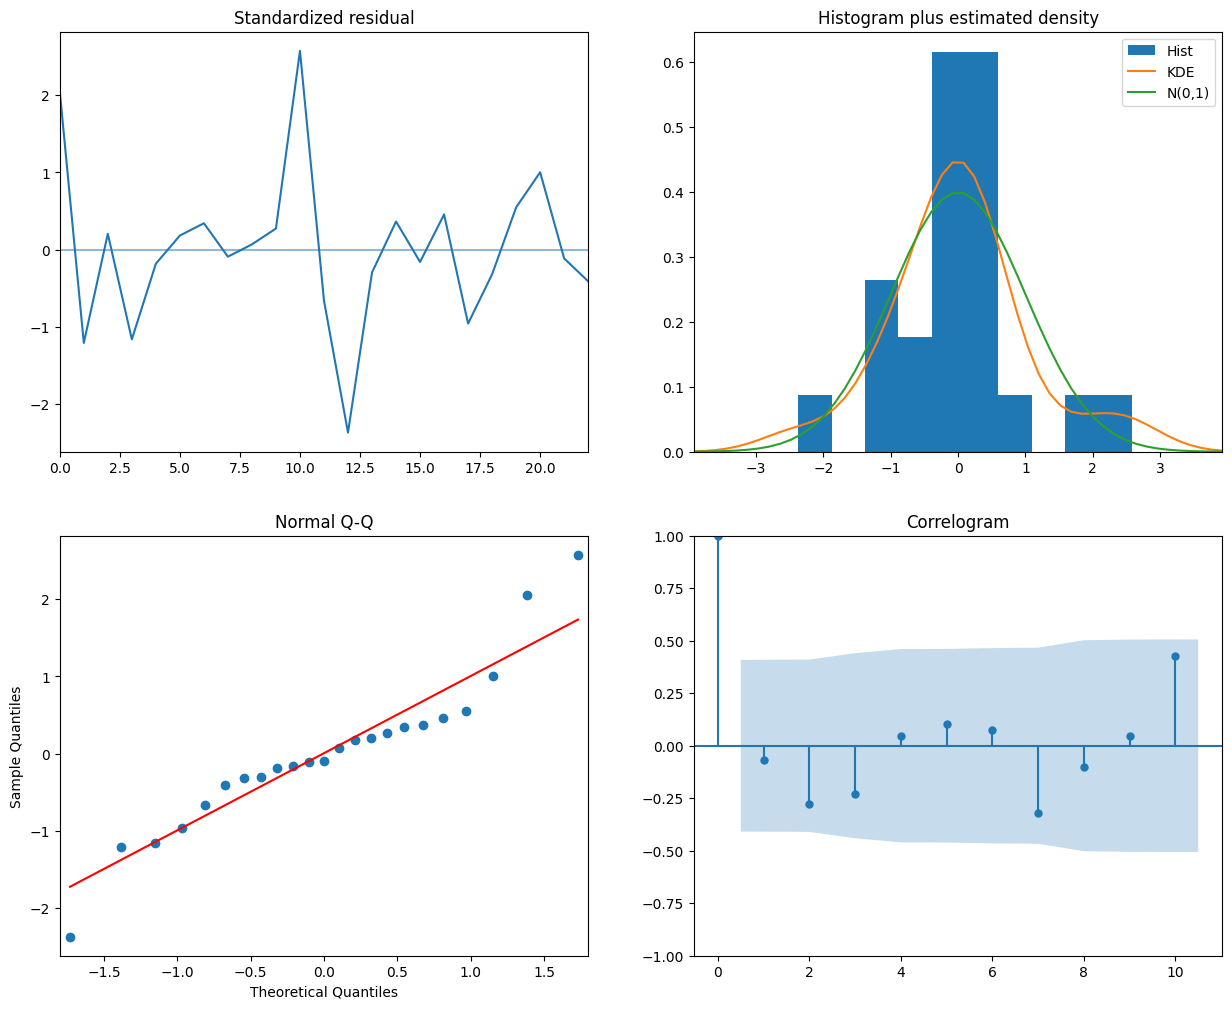

In [38]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

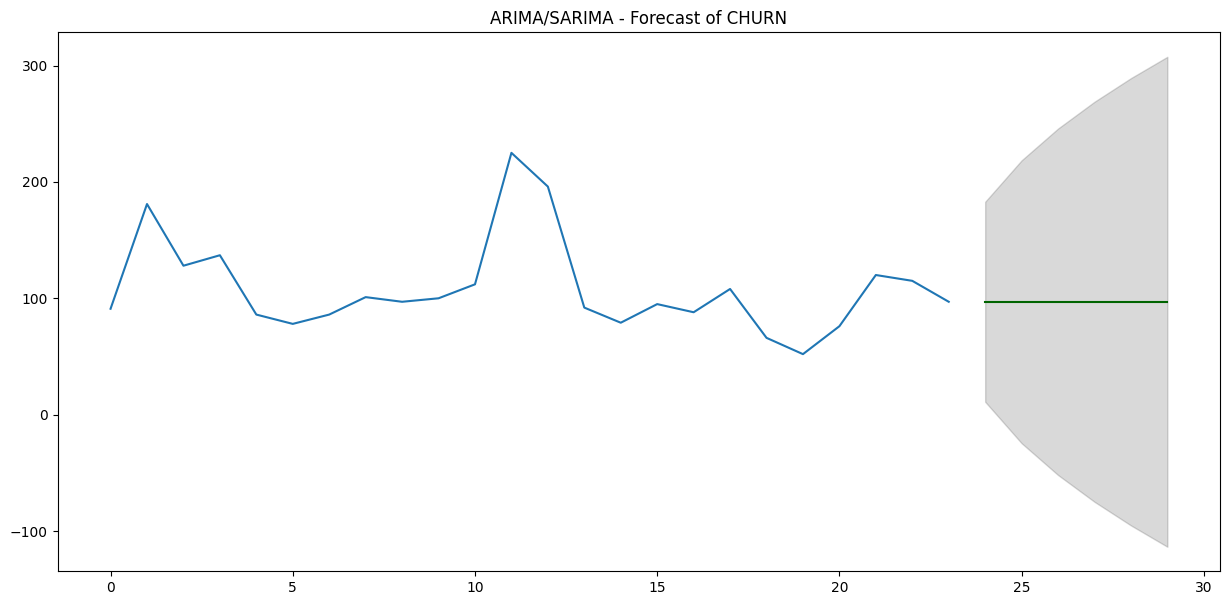

In [39]:
def forecast(ARIMA_model, periods):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.Series(range(final_dataset.index[-1]+1 , final_dataset.index[-1]+1 + periods))

 # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)
    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(final_dataset['CHURN'], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast of CHURN")
    plt.show()

forecast(ARIMA_model,6)

In [40]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(final_dataset['CHURN'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=12, #12 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=0, 
                         D = 1, #order of the seasonal differencing
                         trace=False,
                         error_action='warn',  
                         suppress_warnings=False, 
                         stepwise=True)

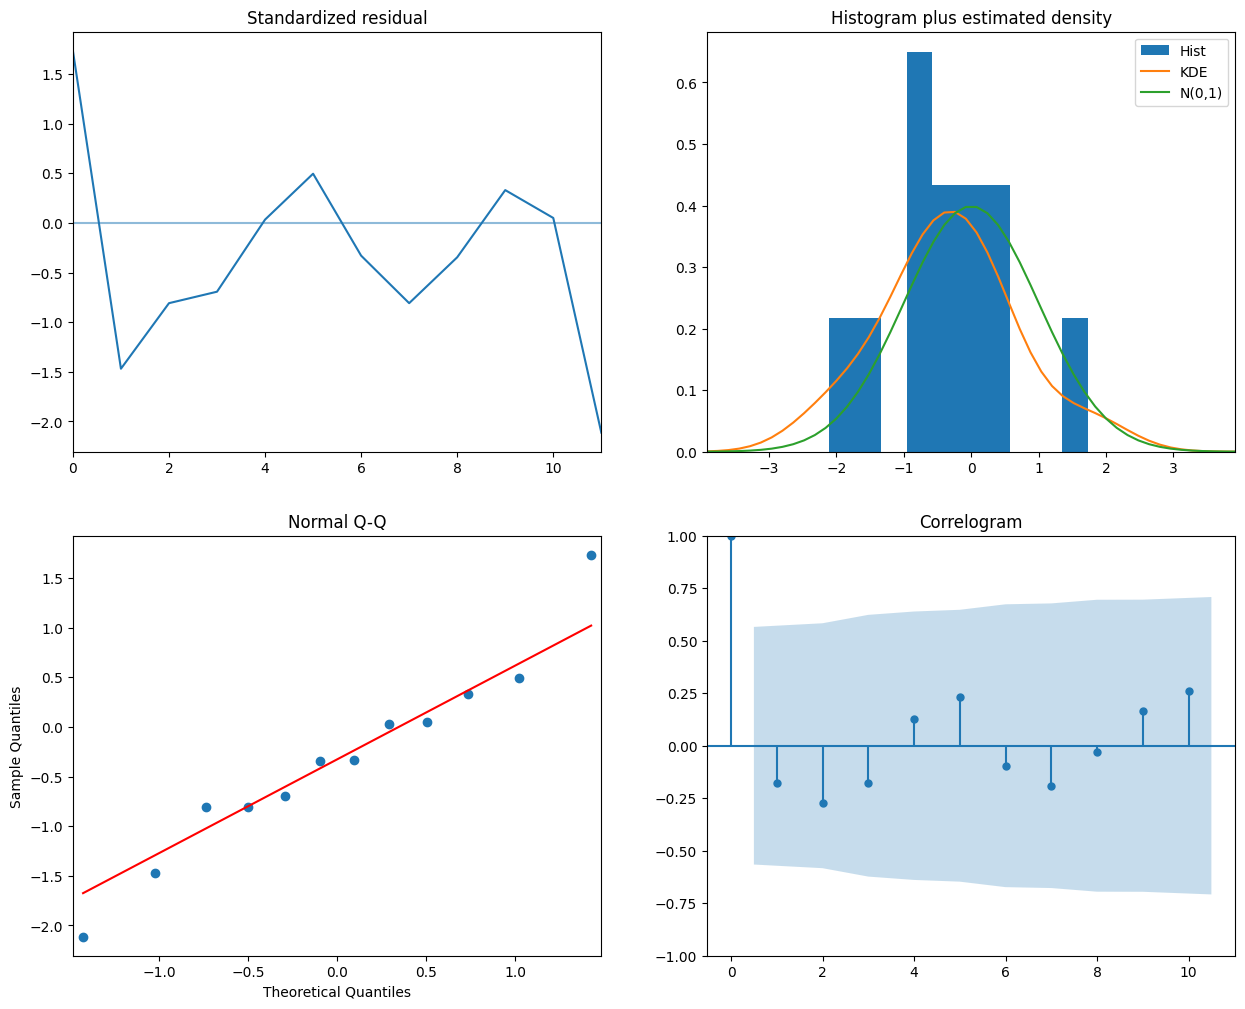

In [41]:
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

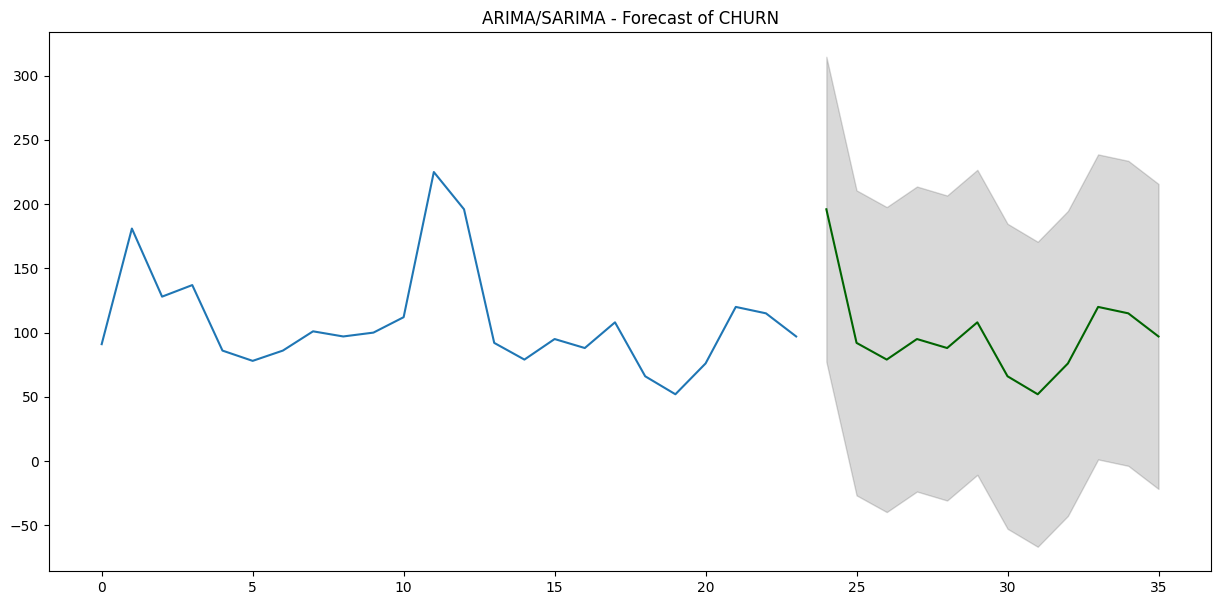

In [42]:
forecast(SARIMA_model,12)

In [43]:
#adding exogenous variable
#final_dataset['month_index'] = final_dataset.index.month

# SARIMAX Model
SARIMAX_model = pm.auto_arima(final_dataset[['CHURN']], exogenous=final_dataset[['Month']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=0, D=1, 
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
get_parametes = SARIMAX_model.get_params()
print(type(get_parametes))
get_parametes

<class 'dict'>


{'maxiter': 50,
 'method': 'lbfgs',
 'order': (0, 0, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 1, 0, 12),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

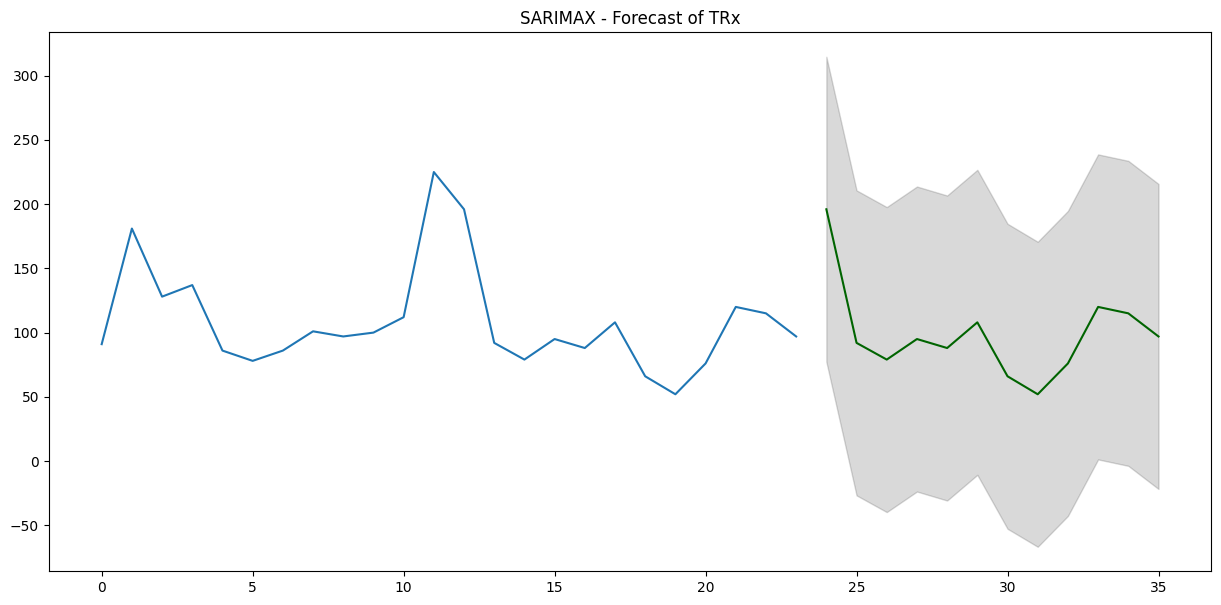

In [44]:
def sarimax_forecast(SARIMAX_model, periods):
    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"month_index":pd.date_range(final_dataset.index[-1], periods = n_periods, freq='MS').month},
                    index = pd.Series(range(final_dataset.index[-1]+1 , final_dataset.index[-1]+1 + periods)))
    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            exogenous=forecast_df[['month_index']])
    index_of_fc = pd.Series(range(final_dataset.index[-1]+1 , final_dataset.index[-1]+1 + periods))

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)
    
    #print(fitted_series)
    #print(lower_series)
    #print(upper_series)
    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(final_dataset['CHURN'], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of TRx")
    plt.show()
    
sarimax_forecast(SARIMAX_model, 12)

In [46]:
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
warnings.filterwarnings("ignore")
organization_unique_values = grouped_data['ORGANIZATION_TYPE'].unique()
forcasted_values = []
n_periods = 25
for org_i in organization_unique_values:
    data = grouped_data[grouped_data['ORGANIZATION_TYPE']  == org_i ]
    org_wise_data = data[['CHURN']].reset_index(drop = True)
    org_wise_data['Month'] = org_wise_data.index+24
    SARIMAX_model = pm.auto_arima(org_wise_data[['CHURN']], exogenous=org_wise_data['Month'],
                        start_p=1, start_q=1,
                        test='adf',
                        max_p=3, max_q=3, m=12,
                        start_P=0, seasonal=True,
                        d=0, D=1, 
                        trace=False,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)
    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.Series(range(org_wise_data.index[-1] , org_wise_data.index[-1] + n_periods))

# make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)
    ts_decompose_multiplicative = seasonal_decompose(fitted, model = 'multiplicative', period=12, extrapolate_trend = 'freq')
    ts_decompose_additive = seasonal_decompose(fitted, model = 'additive', period=12, extrapolate_trend = 'freq')
    forcasted_values.append([fitted,lower_series,upper_series, org_i, ts_decompose_multiplicative.seasonal, ts_decompose_multiplicative.trend, ts_decompose_multiplicative.resid])

In [51]:
forecasted_data = pd.DataFrame(columns=['ORGANIZATION_TYPE','MONTH','FORECASTED_ATTRITION','SEASONAL_COMPONENT','MULTIPLICATIVE_TREND','RESIDUAL','CONFIDENCE_INTERVAL_UPPER','CONFIDENCE_INTERVAL_LOWER'])
 
 
for j in range(len(forcasted_values)):
    for i in range(len(forcasted_values[j][0])):
        forecasted_data.loc[len(forecasted_data.index)] = [forcasted_values[j][3], 25+i ,list(forcasted_values[j][0])[i],list(forcasted_values[j][4])[i],list(forcasted_values[j][5])[i],list(forcasted_values[j][6])[i],list(forcasted_values[j][2])[i],list(forcasted_values[j][1])[i]]

In [52]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
start_date = datetime(2024, 8 ,31)
forecasted_data.loc[:,'DATE'] = forecasted_data.loc[:,'MONTH'].apply(lambda x: start_date + relativedelta(months = x-24))

In [53]:
forecasted_data

,ORGANIZATION_TYPE,MONTH,FORECASTED_ATTRITION,SEASONAL_COMPONENT,MULTIPLICATIVE_TREND,RESIDUAL,CONFIDENCE_INTERVAL_UPPER,CONFIDENCE_INTERVAL_LOWER,DATE
0,Aerospace,25,196,2,99,1,315,77,2024-09-30
1,Aerospace,26,92,1,99,1,211,-27,2024-10-31
2,Aerospace,27,79,1,99,1,198,-40,2024-11-30
3,Aerospace,28,95,1,99,1,214,-24,2024-12-31
4,Aerospace,29,88,1,99,1,207,-31,2025-01-31
...,...,...,...,...,...,...,...,...,...
395,Utilities,45,68,1,98,1,236,-100,2026-05-31
396,Utilities,46,115,1,98,1,283,-53,2026-06-30
397,Utilities,47,117,1,98,1,285,-51,2026-07-31
398,Utilities,48,102,1,98,1,270,-66,2026-08-31


In [54]:
sf_df = my_session.createDataFrame(forecasted_data)
sf_df.write.mode("overwrite").save_as_table("Frorecasted_Attrition_Dataset")
my_session.table("Frorecasted_Attrition_Dataset").show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORGANIZATION_TYPE"  |"MONTH"  |"FORECASTED_ATTRITION"  |"SEASONAL_COMPONENT"  |"MULTIPLICATIVE_TREND"  |"RESIDUAL"          |"CONFIDENCE_INTERVAL_UPPER"  |"CONFIDENCE_INTERVAL_LOWER"  |"DATE"               |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|Aerospace            |25       |196.0                   |1.9864864864864866    |98.66666666666667       |0.9999999999999999  |314.7199785480145            |77.28002145198546            |2024-09-30 00:00:00  |
|Aerospace            |26       |92.0                    |0.9324324324324327    |98.66666666666667       |0.9999999999999997  |210.71997854801452           |-26